# Obtain correlation heatmap of the summary statitstics for the DTD dataset

## Packages


In [4]:
import sys
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
sys.path.append('../')  
sys.path.append('../../')  
sys.path.append('../../PooledStatisticsMetamers')
sys.path.append('../../PyTorchSteerablePyramid')
sys.path.append('../Poolstatmetamer_croppedims')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pytorch_metric_learning import losses
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

sys.path.append('../PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch
import utils.brucenet as bn
import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
dtd_folder = 'home/gridsan/ckoevesdi/data/OT/dtd_torch/dtd/'

cuda:0


In [5]:
loading_transforms = transforms.Compose([
    transforms.CenterCrop(size=256),
    transforms.Grayscale(),
    transforms.ToTensor(),  # This will also convert the image from [0, 255] to [0.0, 1.0]
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
class_dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/OT/dtd_torch/', split='train', 
                                             partition=10, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen
# Define the batch size (Change this based on your requirements)
batch_size = 1

# Create a DataLoader
classification_dataloader = DataLoader(
    class_dtd_dataset,
    batch_size=batch_size,
    shuffle=False
)
tensor2pil_transform = transforms.ToPILImage()

In [6]:
# Define the labels of the statistics
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'magnitude_mean 1 0', 'magnitude_variance 1 0', 'magnitude_correlation (1, 2) 0', 'end_stopped 1 0', 'magnitude_mean 1 1', 'magnitude_variance 1 1', 'magnitude_correlation (1, 2) 1', 'end_stopped 1 1', 'magnitude_mean 1 2', 'magnitude_variance 1 2', 'magnitude_correlation (1, 2) 2', 'end_stopped 1 2', 'magnitude_mean 1 3', 'magnitude_variance 1 3', 'magnitude_correlation (1, 2) 3', 'end_stopped 1 3', 'magnitude_correlation 1 (0, 1)', 'magnitude_correlation 1 (0, 2)', 'magnitude_correlation 1 (0, 3)', 'magnitude_correlation 1 (1, 2)', 'magnitude_correlation 1 (1, 3)', 'magnitude_correlation 1 (2, 3)', 'magnitude_mean 2 0', 'magnitude_variance 2 0', 'magnitude_correlation (2, 3) 0', 'end_stopped 2 0', 'magnitude_mean 2 1', 'magnitude_variance 2 1', 'magnitude_correlation (2, 3) 1', 'end_stopped 2 1', 'magnitude_mean 2 2', 'magnitude_variance 2 2', 'magnitude_correlation (2, 3) 2', 'end_stopped 2 2', 'magnitude_mean 2 3', 'magnitude_variance 2 3', 'magnitude_correlation (2, 3) 3', 'end_stopped 2 3', 'magnitude_correlation 2 (0, 1)', 'magnitude_correlation 2 (0, 2)', 'magnitude_correlation 2 (0, 3)', 'magnitude_correlation 2 (1, 2)', 'magnitude_correlation 2 (1, 3)', 'magnitude_correlation 2 (2, 3)', 'magnitude_mean 3 0', 'magnitude_variance 3 0', 'magnitude_correlation (3, 4) 0', 'end_stopped 3 0', 'magnitude_mean 3 1', 'magnitude_variance 3 1', 'magnitude_correlation (3, 4) 1', 'end_stopped 3 1', 'magnitude_mean 3 2', 'magnitude_variance 3 2', 'magnitude_correlation (3, 4) 2', 'end_stopped 3 2', 'magnitude_mean 3 3', 'magnitude_variance 3 3', 'magnitude_correlation (3, 4) 3', 'end_stopped 3 3', 'magnitude_correlation 3 (0, 1)', 'magnitude_correlation 3 (0, 2)', 'magnitude_correlation 3 (0, 3)', 'magnitude_correlation 3 (1, 2)', 'magnitude_correlation 3 (1, 3)', 'magnitude_correlation 3 (2, 3)', 'magnitude_mean 4 0', 'magnitude_variance 4 0', 'end_stopped 4 0', 'magnitude_mean 4 1', 'magnitude_variance 4 1', 'end_stopped 4 1', 'magnitude_mean 4 2', 'magnitude_variance 4 2', 'end_stopped 4 2', 'magnitude_mean 4 3', 'magnitude_variance 4 3', 'end_stopped 4 3', 'magnitude_correlation 4 (0, 1)', 'magnitude_correlation 4 (0, 2)', 'magnitude_correlation 4 (0, 3)', 'magnitude_correlation 4 (1, 2)', 'magnitude_correlation 4 (1, 3)', 'magnitude_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

## Load images and encode

In [7]:
#Load image encoder
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     256,
                                     256)).to(device)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Encode images

In [8]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(classification_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    output = texture_batch.to(device)
    output = torch.stack([output, output]).squeeze(1)
    #print(output.shape)
    #print(labels)
    statistics = brucy(output)  # This should output a tensor of shape [2, 150]
    statistics = statistics[0,:]
    #print(statistics[0,:])
    # You can now store these statistics, along with the label and original image index
    all_statistics.append({
        'statistics': statistics.cpu().numpy(),
        #'label': labels[i].item(),
        'original_image_index': labels.cpu().numpy()
    })

#### Normalize statistics

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
labels_array = np.array([item['original_image_index'] for item in all_statistics])
print(statistics_array.shape)

# Standardize
scaler = StandardScaler()
scaled_array = scaler.fit_transform(statistics_array)

# Convert NumPy arrays to PyTorch tensors
statistics_tensor = torch.tensor(scaled_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)


(4183, 150)


### Plot heatmap of correlation matrix

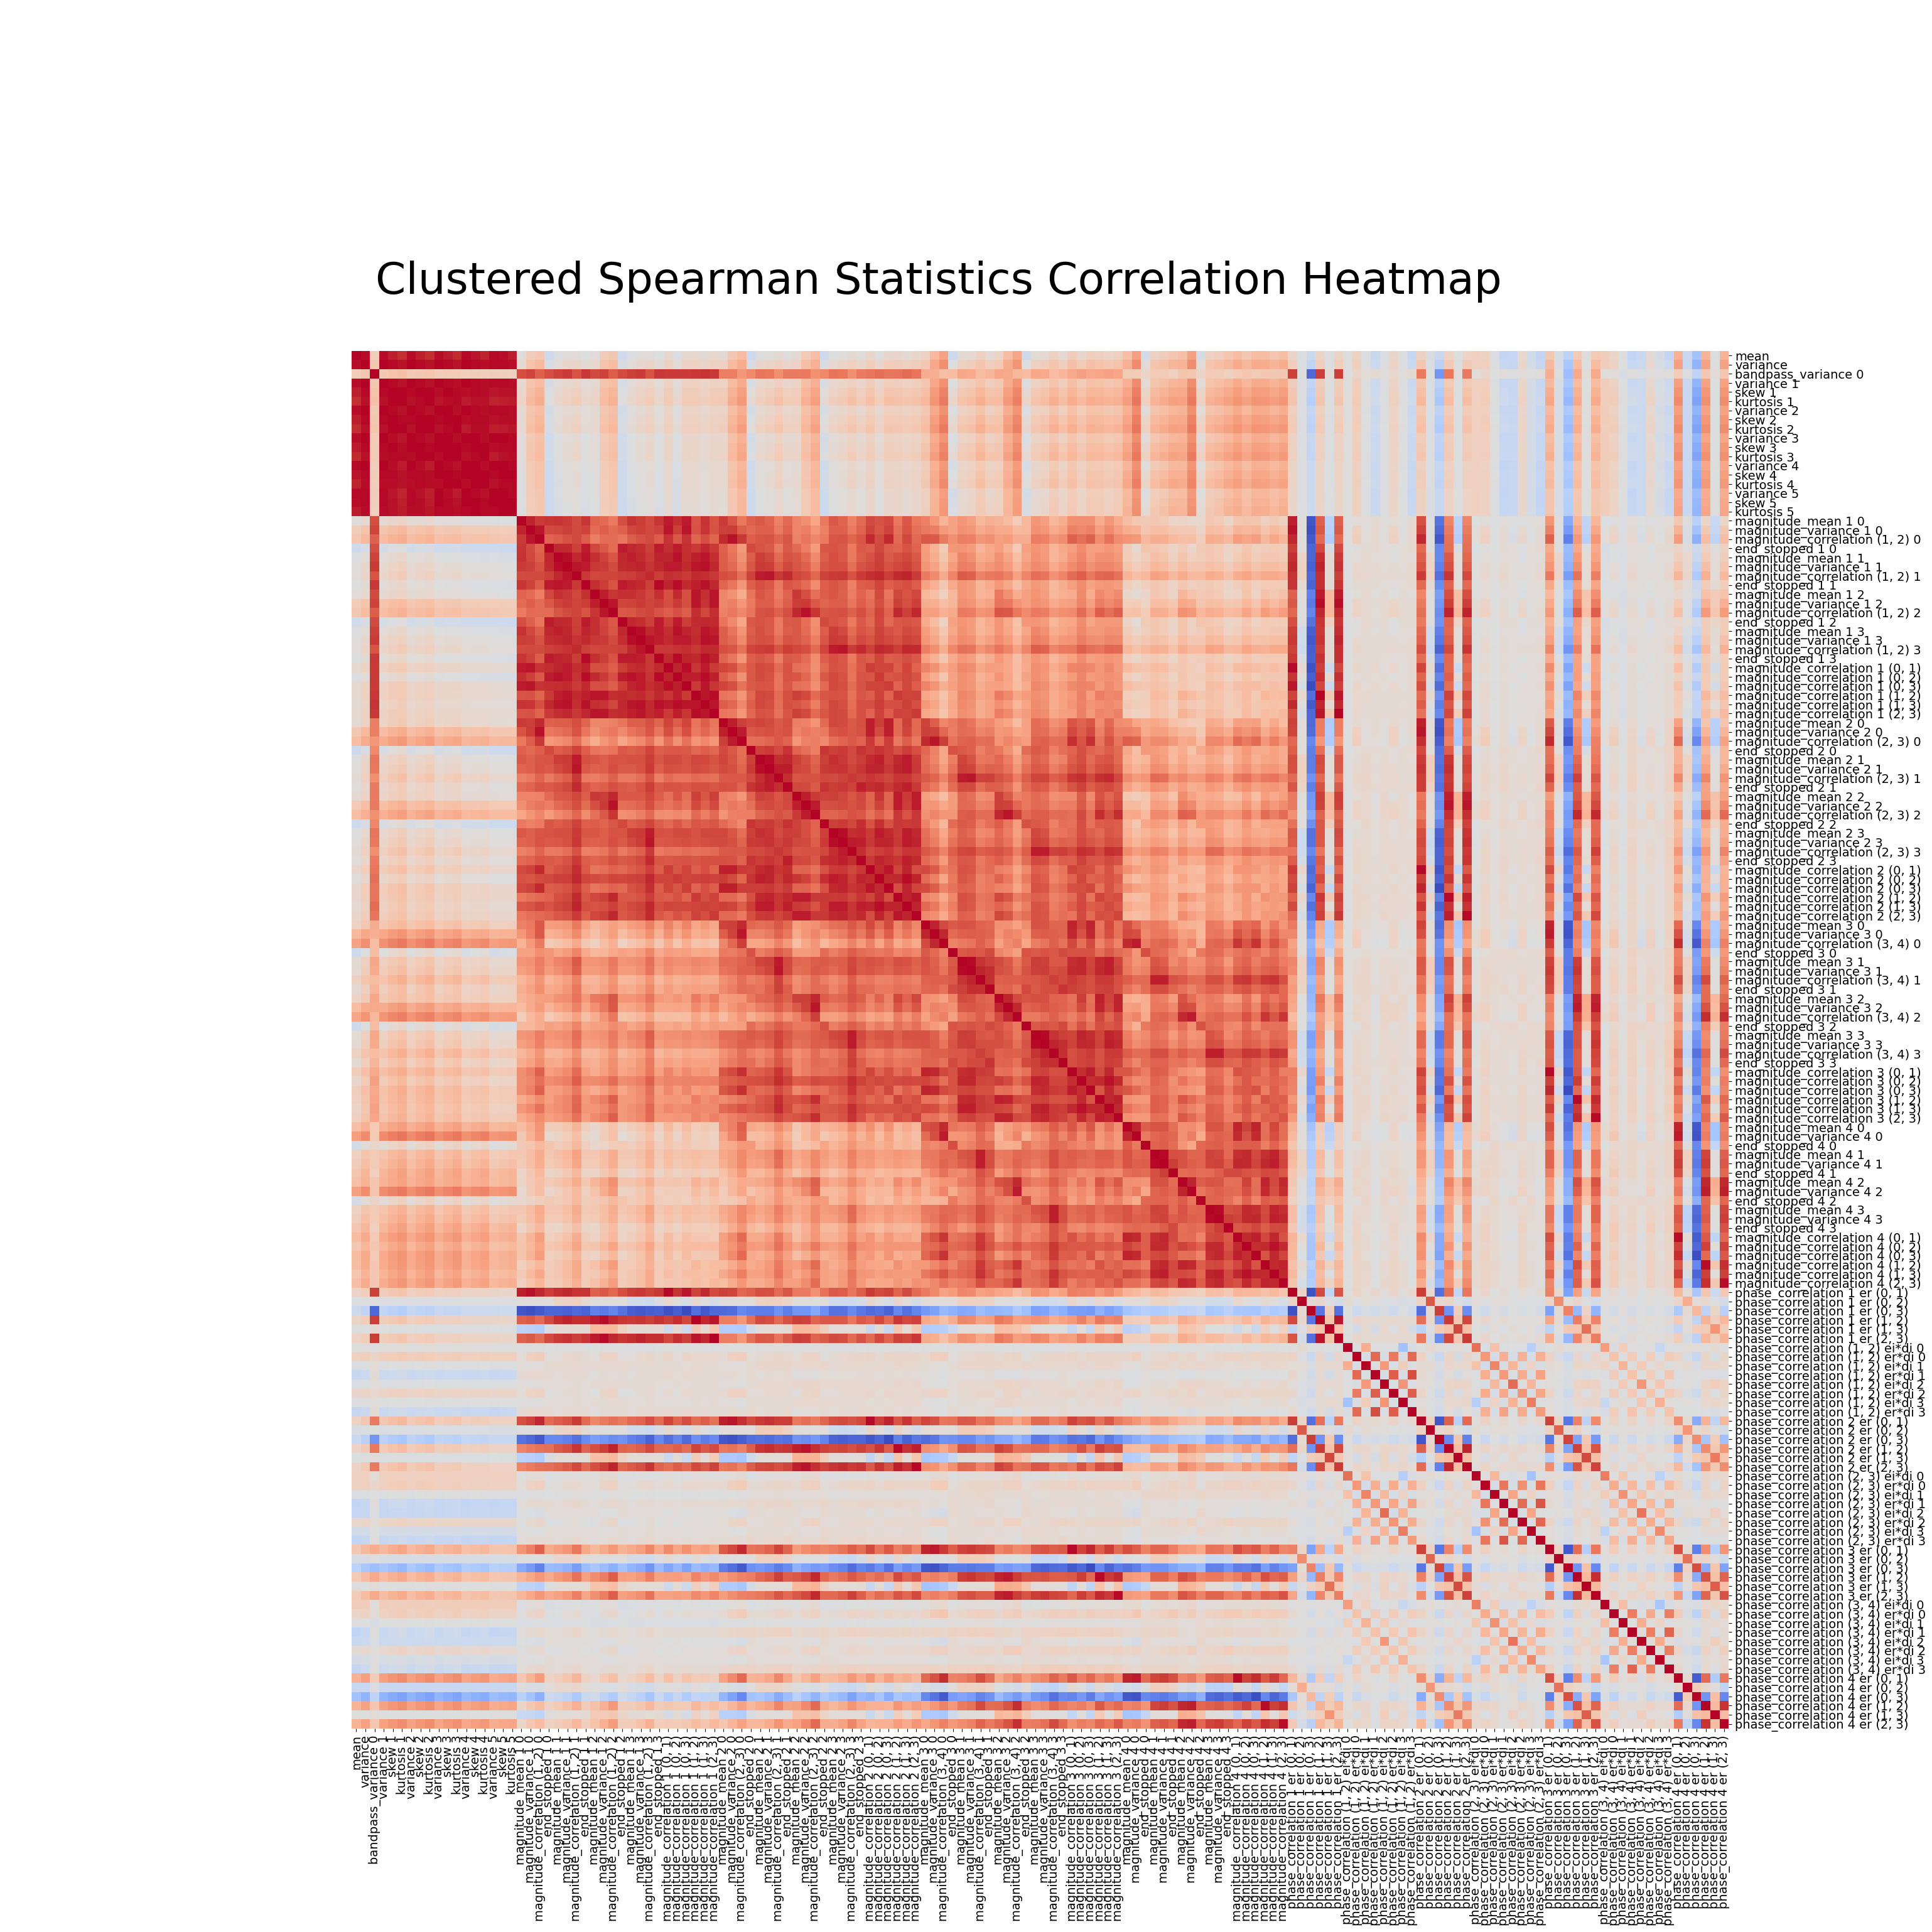

In [10]:
# Assuming scaled_array contains your scaled features
df = pd.DataFrame(scaled_array, columns=ostat_labels)  # Assuming ostat_labels are your feature names

spearman_corr_matrix = df.corr(method='spearman')
cluster_map = sns.clustermap(spearman_corr_matrix, method='average', cmap='coolwarm', figsize=(30, 30), 
               row_cluster=False, col_cluster=False, xticklabels=True, yticklabels=True)

# Set title closer to the heatmap
cluster_map.fig.suptitle('Clustered Spearman Statistics Correlation Heatmap', fontsize=50, y=0.86)
cluster_map.ax_heatmap.tick_params(axis='both', which='both', labelsize=14)  # Adjust label size here

# Hide the colorbar
cluster_map.cax.set_visible(False)

plt.show()



